In [3]:
import os
import sys
import pickle
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering


from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True})

In [2]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

def extract_clp_results(clustering_dict, Nframes, Nexp, rmax_list, act_list, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    LX = clustering_dict['LX']
    suffix = clustering_dict['suffix']
    Nwindows = len(rmax_list)
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, Nwindows, 3, len(act_list), Nexp])
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            cl_res = np.load(os.path.join(exp_dir, 'cl_arr.npy'))[-Nframes:]
            cluster_arr[:,:cl_res.shape[1],:,i,j] = cl_res

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        defect_positions[i] = *defect['pos'], defect['charge'] if return_charge else defect['pos']
    return defect_positions

def get_clustering_signed(top_defect_list, method, rmax_list, method_kwargs, save = False, save_path = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)
        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        if defect_positions is None:
            continue

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs)
            labels = cst.fit_predict(defect_positions)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

    if save:
        # save labels list
        save_path = save_path if save_path is not None else 'labels_list.pkl'
        np.save(save_path, cl_arr)
    return cl_arr

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1

In [4]:
extract = False
save_figs = False

LX = 2048
output_path = f'data\\nematic_analysis{LX}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LX, mode)
ad = AnalyseDefects(defect_list, output_path=output_path)

fig_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Figures\\cl_perc'
base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\na{LX}clp'

if not os.path.isdir(fig_path):
    os.makedirs(fig_path)

Nframes_l = 400 if LX < 2048 else 180
Nframes_vl = 1500 if LX < 2048 else 400
rmax_list_l = np.arange(10, 500)
rmax_list_vl = np.arange(10, 1500)

d_cluster_l = dict(path = base_path + '_clp', \
            suffix = "_clp", priority = 1, LX = LX, Nframes = Nframes_l)
d_cluster_vl = dict(path = base_path + 'l_clp', \
            suffix = "_l_clp", priority = 1, LX = LX, Nframes = Nframes_vl)
    
    
Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
conv_list_l = len(act_l) * [0]
conv_list_vl = ad.conv_list[-1]
act_list_full = act_vl + act_l

if extract:
    act_idx = ad.act_list[0].index(act_l[0])
    clp_arr = extract_clp_results(d_cluster_l, Nframes_l, len(Nexp_l), 
                                rmax_list_l, act_l, act_dir_l,
                                save_path=out_path)
    clp_arr_l = extract_clp_results(d_cluster_vl, Nframes_vl, len(Nexp_vl), 
                                rmax_list_vl, act_vl, act_dir_vl,
                                save_path=out_path)
else:
    clp_arr = np.load(os.path.join(out_path, 'arr_clp.npy'))
    clp_arr_l = np.load(os.path.join(out_path, 'arr_l_clp.npy'))

# Discard exp 1 for act 0.0195
act_idx = act_vl.index(0.0195)
clp_arr_l[:,:, :, act_idx, 1] = np.nan

In [5]:
uncertainty_multiplier = 5
ncutoff_frac_lower = .05

arg_func1d = lambda arr: arg_func(arr, rmax_list_l, cutoff = 1)
arg_func1d_vl = lambda arr: arg_func(arr, rmax_list_vl, cutoff = 1)
lmax_arr_l = np.apply_along_axis(arg_func1d_vl, axis=1, arr=clp_arr_l[:, :, -1, :, :])
lmax_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, -1, :, :])
lperc_arr_l = np.apply_along_axis(arg_func1d_vl, axis=1, arr=clp_arr_l[:, :, 0, :, :])
lperc_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, 0, :, :])

idx_arr_l = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_l[:, :, 0, :, :])
idx_arr = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr[:, :, 0, :, :])
qmax_arr_l = np.nan * np.zeros_like(idx_arr_l)
qmax_arr = np.nan * np.zeros_like(idx_arr)


lmax_av_l = np.nan * np.zeros((len(act_vl), 2))
lmax_av = np.nan * np.zeros((len(act_l), 2))
lperc_av_l = np.nan * np.zeros((len(act_vl), 2))
lperc_av = np.nan * np.zeros((len(act_l), 2))

for i, _ in enumerate(act_vl):
    ff_idx = conv_list_vl[i]

    mask = (lmax_arr_l[ff_idx:, i, :] > 0)
    nsamples = mask.sum()
    if nsamples / lmax_arr_l[ff_idx:, i, :].size > ncutoff_frac_lower:
        arr_res = lmax_arr_l[ff_idx:, i, :][mask]
        lmax_av_l[i,0] = np.nanmean(arr_res)
        lmax_av_l[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)

    mask_perc = (lperc_arr_l[ff_idx:, i, :] > 0)
    nsamples_perc = mask_perc.sum()
    if nsamples_perc / lperc_arr_l[ff_idx:, i, :].size > ncutoff_frac_lower:
        arr_res_perc = lperc_arr_l[ff_idx:, i, :][mask_perc]
        lperc_av_l[i,0] = np.nanmean(arr_res_perc)#np.nanmean(lperc_arr_l[ff_idx:, i, :], axis=(0,-1))
        lperc_av_l[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    for f in range(ff_idx, Nframes_vl):

        arr_idx = idx_arr_l[f, i,:]
        qmax_arr_l[f, i] = np.diag(clp_arr_l[f, arr_idx, 1, i, :])

   # print(act_vl[i], nsamples, nsamples_perc)

for i, _ in enumerate(act_l):
    ff_idx = conv_list_l[i]

    mask = (lmax_arr[ff_idx:, i, :] > 0)
    nsamples = mask.sum()
    if nsamples / lmax_arr[ff_idx:, i, :].size > ncutoff_frac_lower:
        arr_res = lmax_arr[ff_idx:, i, :][mask]
        lmax_av[i,0] = np.nanmean(arr_res)#np.nanmean(lmax_arr[ff_idx:, i, :], axis=(0,-1))
        lmax_av[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)

    mask_perc = (lperc_arr[ff_idx:, i, :] > 0)
    nsamples_perc = mask_perc.sum()

    if nsamples_perc / lperc_arr[ff_idx:, i, :].size > ncutoff_frac_lower:

        arr_res_perc = lperc_arr[ff_idx:, i, :][mask_perc]
        lperc_av[i,0] = np.nanmean(arr_res_perc)#np.nanmean(lperc_arr[ff_idx:, i, :], axis=(0,-1))
        lperc_av[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    for f in range(ff_idx, Nframes_l):

        arr_idx = idx_arr[f, i,:]
        qmax_arr[f, i] = np.diag(clp_arr[f, arr_idx, 1, i, :])

    #print(act_l[i], nsamples, nsamples_perc)


 #   print(act_l[i], nsamples, nsamples_perc, nsamples_perc / lperc_arr[ff_idx:, i, :].size)

lmax_full = np.concatenate([lmax_av_l, lmax_av], axis=0)
lperc_full = np.concatenate([lperc_av_l, lperc_av], axis=0)


## Total charge is not generally 0. This must be accounted for

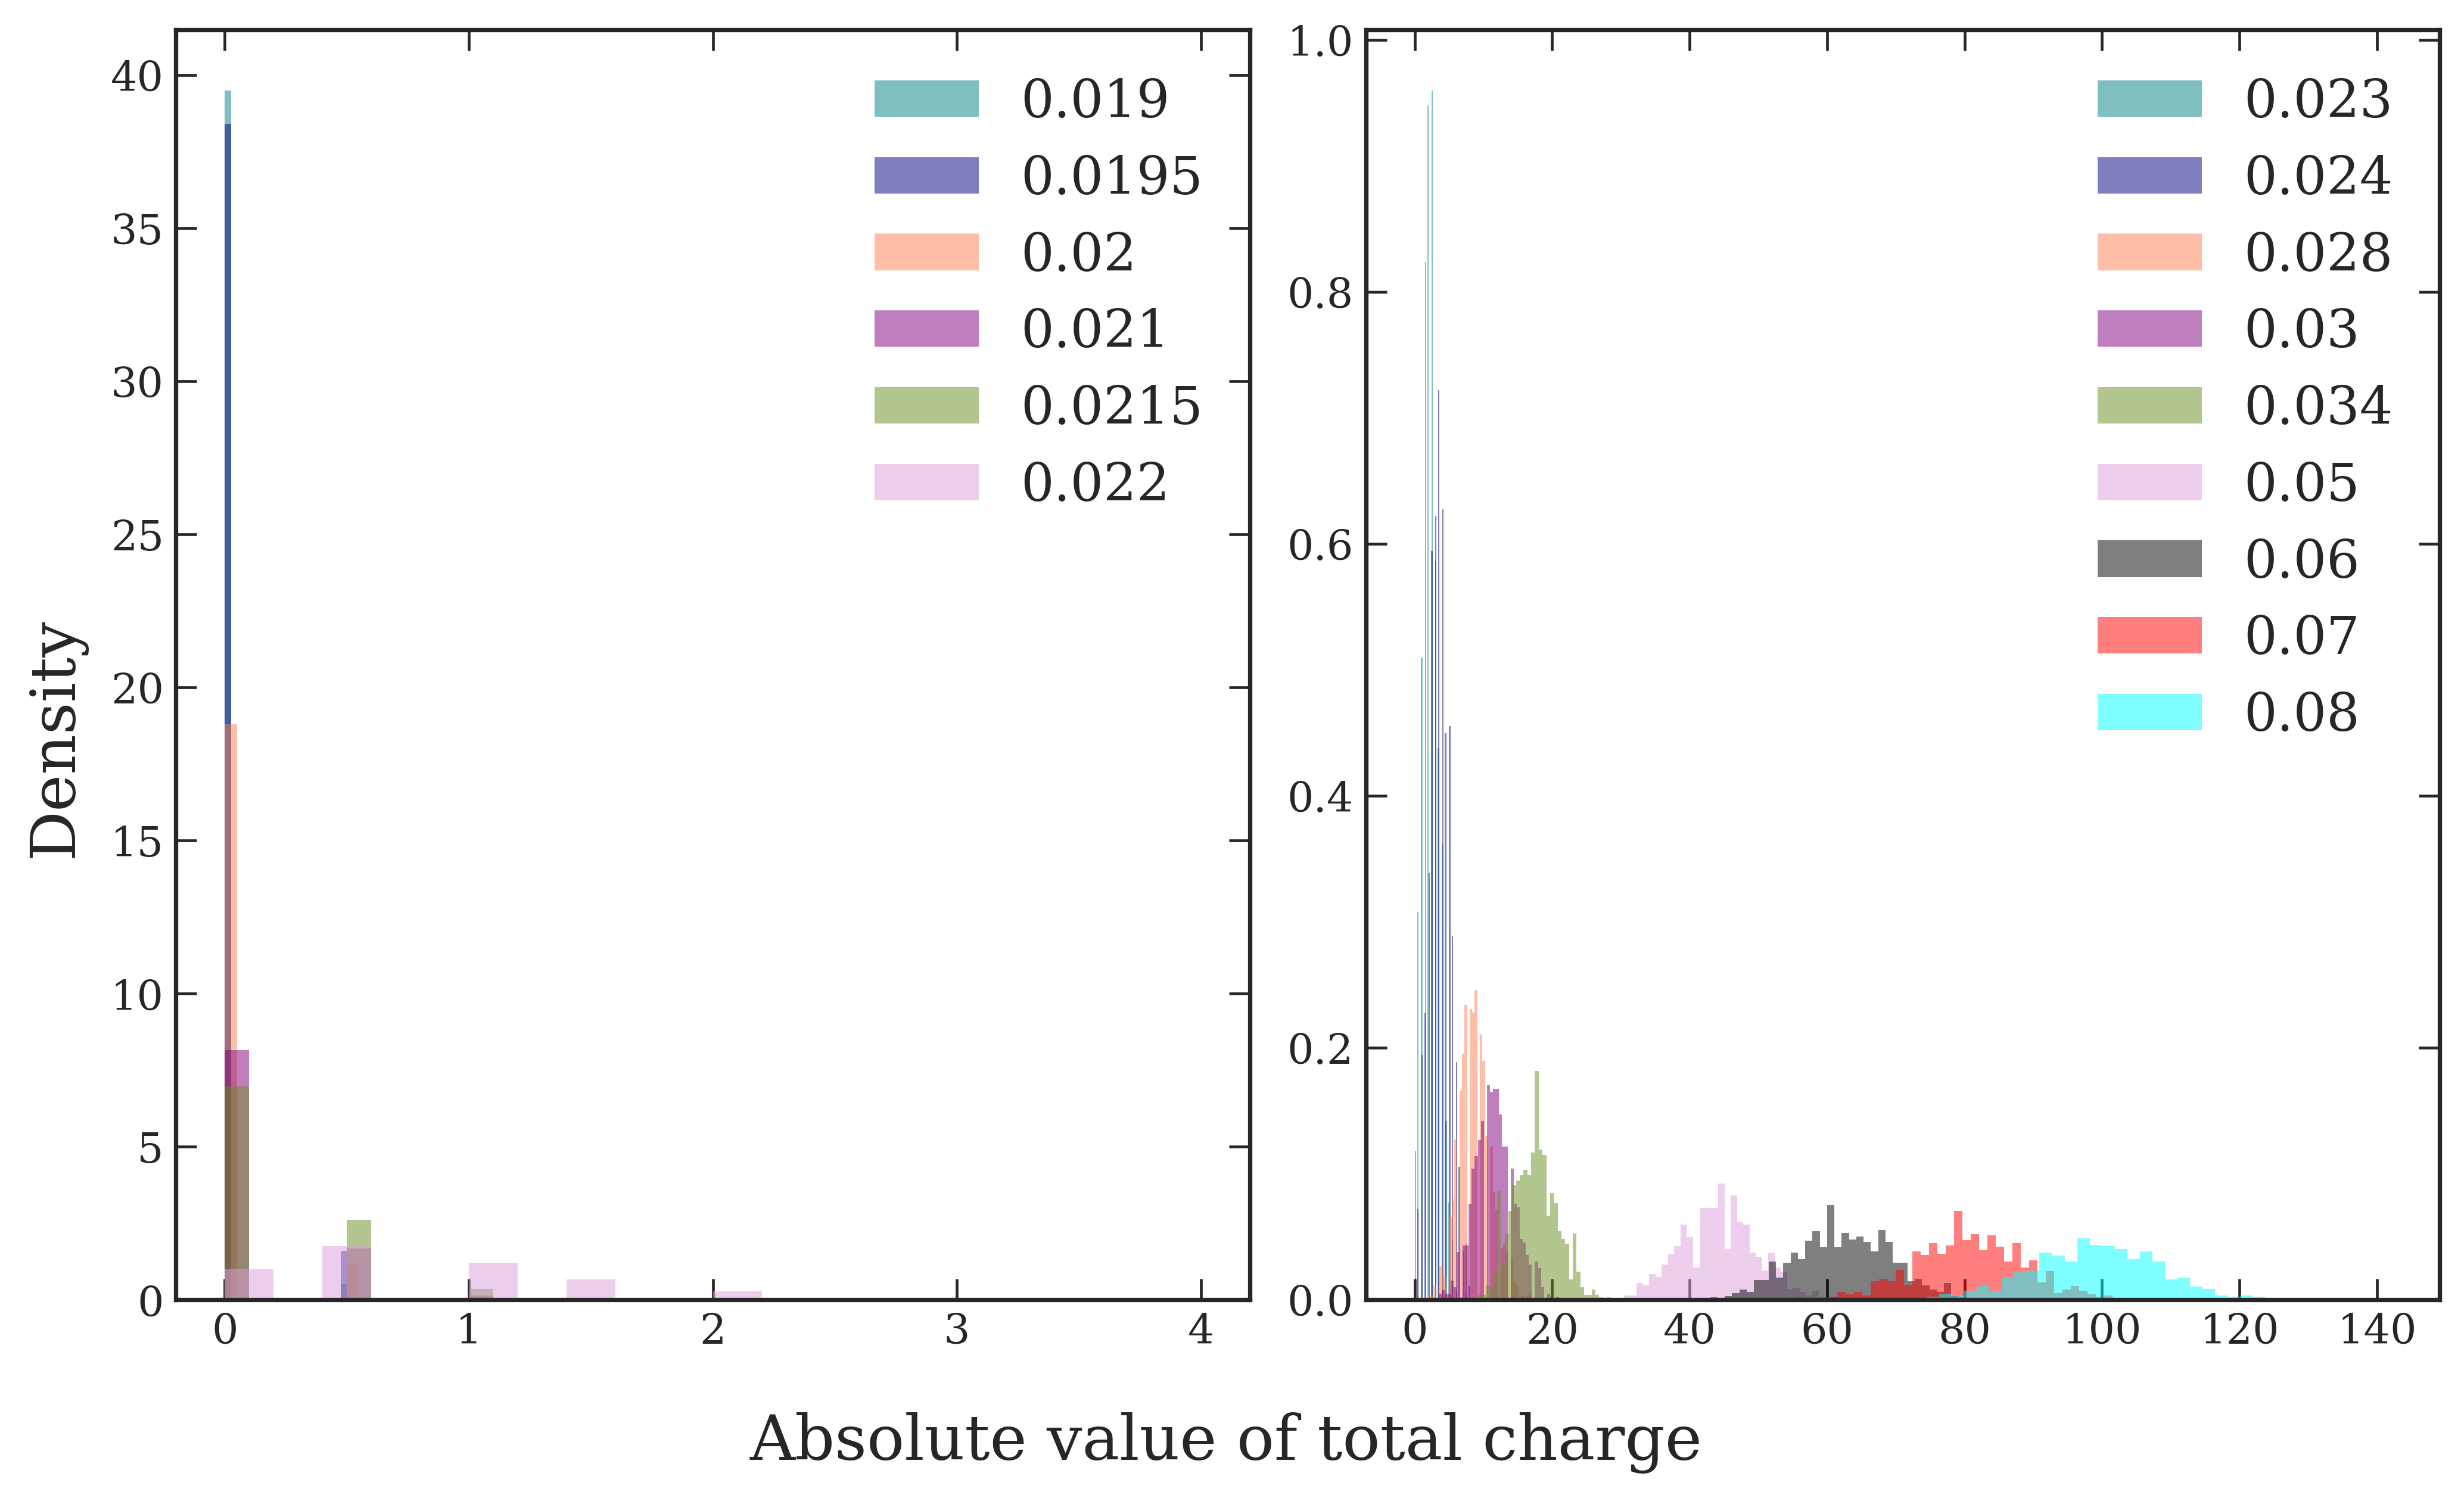

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax = ax.flatten()
for i, act in enumerate(act_vl):
    ff_idx = conv_list_vl[i]
    vals = qmax_arr_l[ff_idx:, i].flatten() #/ (av_def[i,0] )  
    ax[0].hist(vals[~np.isnan(vals)], bins = 20, alpha = .5, label = act, density=True)
    
for i, act in enumerate(act_l):
    if act in [0.025, 0.15]:
        continue
    ff_idx = conv_list_l[i]
    vals = qmax_arr[ff_idx:, i].flatten() #/ (av_def[i,0] )  
    ax[1].hist(vals[~np.isnan(vals)], bins = 40, alpha = .5, label = act, density=True)
ax[0].legend()
ax[1].legend()
fig.supylabel('Density')
fig.supxlabel('Absolute value of total charge')

if save_figs:
    fig.savefig(os.path.join(fig_path, 'qmax_hist.png'), bbox_inches = 'tight', dpi = 420)

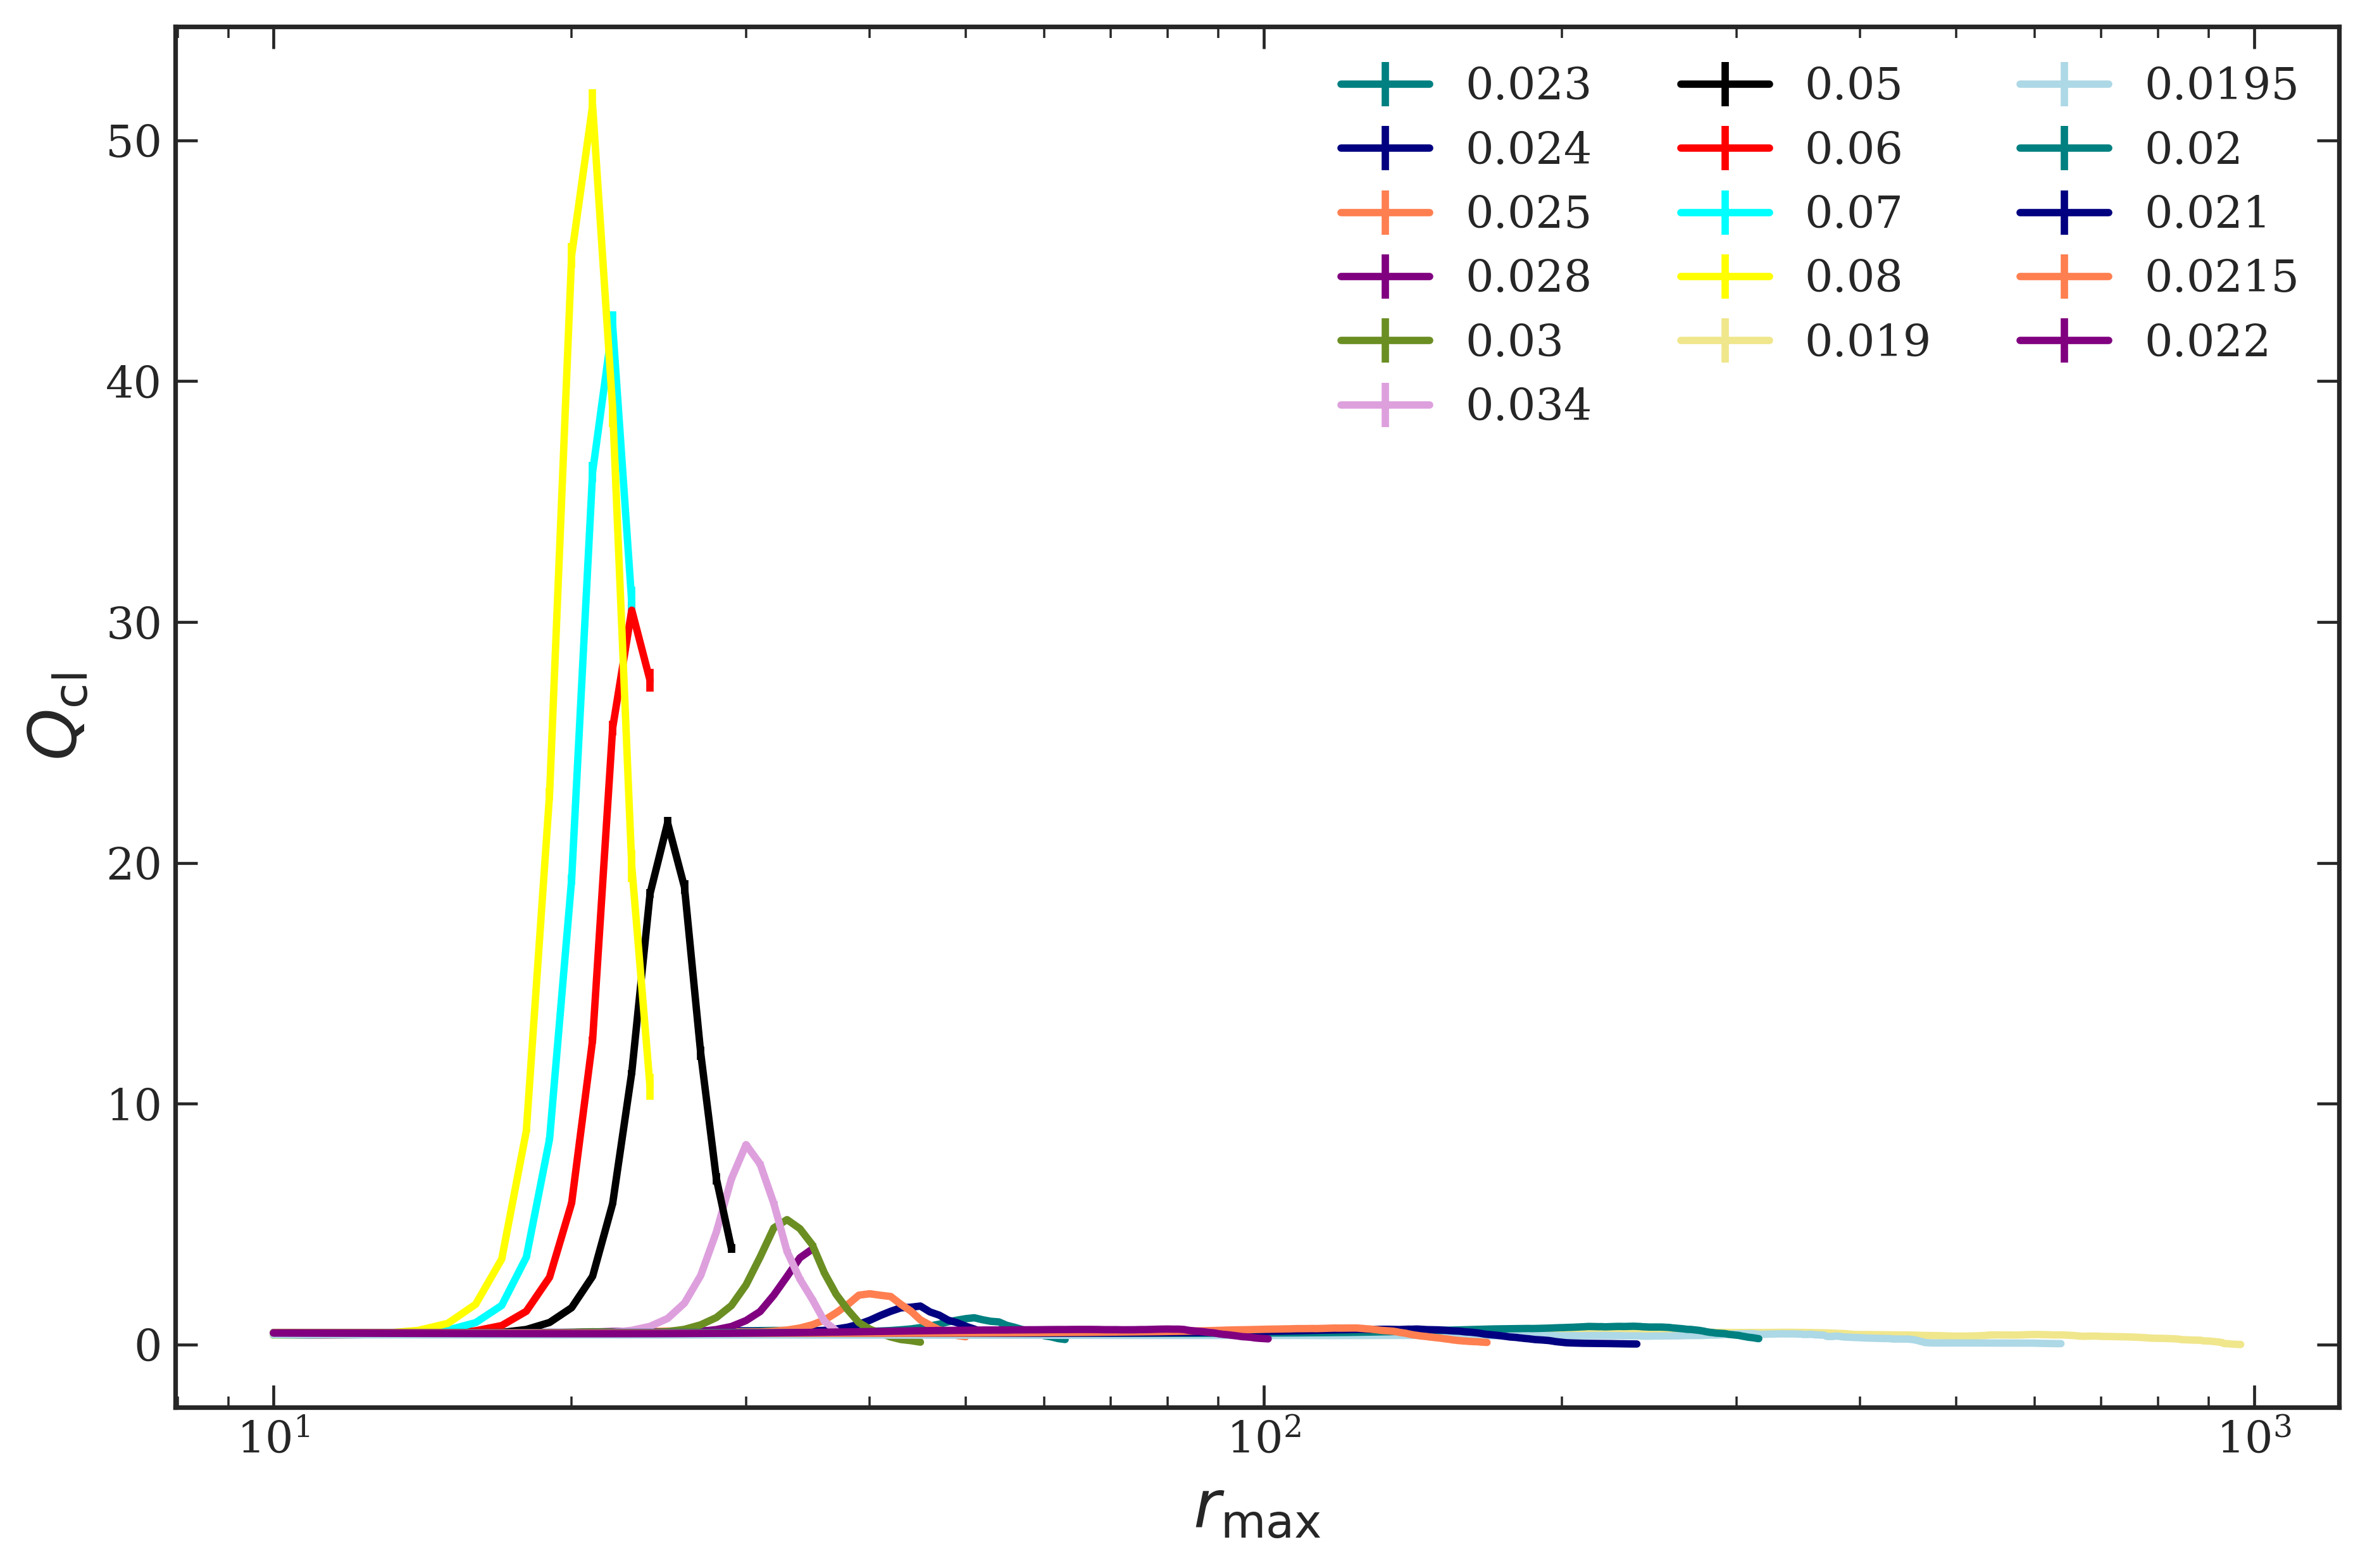

In [66]:
fig, ax = plt.subplots()

for i, act in enumerate(act_l):
    if act > 0.1:
        continue
    ff_idx = int(conv_list_l[i])
    vals = clp_arr[ff_idx:, :, 1, i, :]
    max_idx = int(np.max(idx_arr[ff_idx, i,:]))
    vals = np.nan_to_num(vals[:,:max_idx,:],)
    qav = np.nanmean(vals, axis=(0,-1))
    qstd = np.nanstd(vals, axis=(0,-1)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax.errorbar(rmax_list_l[:max_idx], qav, qstd, label=f'{act}')

for i, act in enumerate(act_vl):
    ff_idx = int(conv_list_vl[i])
    vals = clp_arr_l[ff_idx:, :, 1, i, :]
    max_idx = int(np.max(idx_arr_l[ff_idx, i,:]))
    vals = np.nan_to_num(vals[:,:max_idx,:],)

    qav = np.nanmean(vals, axis=(0,-1))
    qstd = np.nanstd(vals, axis=(0,-1)) \
    / np.sqrt((vals.size / uncertainty_multiplier))

    ax.errorbar(rmax_list_vl[:max_idx], qav, qstd, label=f'{act}')

ax.legend()
ax.legend(ncols=3,fontsize=12)
ax.set_xscale('log')

ax.set_xlabel(r'$r_{\max}$')
ax.set_ylabel(r'$Q_{\mathrm{cl}}$')
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, 'qcl.png'), bbox_inches = 'tight', dpi = 420)

In [38]:
qarr_shifted = np.nan * np.zeros((Nframes_l, len(rmax_list_l), len(act_l), len(Nexp_l)))
qarr_l_shifted = np.nan * np.zeros((Nframes_vl, len(rmax_list_vl), len(act_vl), len(Nexp_vl)))
q_av = np.nan * np.zeros((len(act_l), len(rmax_list_l), 2))
q_av_l = np.nan * np.zeros((len(act_vl), len(rmax_list_vl), 2))

for i, act in enumerate(act_l):
    qarr_shifted[:,:, i, : ] = clp_arr[:, :, 1, i,:] - qmax_arr[:,i,:][:, None, :] / clp_arr[:, :, 0, i,:]
for i, act in enumerate(act_vl):
    qarr_l_shifted[:,:, i, : ] = clp_arr_l[:, :, 1, i,:] - qmax_arr_l[:,i,:][:, None, :] / clp_arr_l[:, :, 0, i,:]

# replace nan values with 0
np.nan_to_num(qarr_shifted, copy = False)
np.nan_to_num(qarr_l_shifted, copy = False)

for i, act in enumerate(act_l):
    ff_idx = conv_list_l[i]
    nsamples = qarr_shifted[ff_idx:, 0, i, :].size
    q_av[i, :, 0] = np.nanmean(qarr_shifted[ff_idx:, :, i, :], axis=(0,-1))
    q_av[i, :, 1] = np.nanstd(qarr_shifted[ff_idx:, :, i, :], axis=(0,-1)) \
    / np.sqrt(nsamples / uncertainty_multiplier)

for i, act in enumerate(act_vl):
    ff_idx = conv_list_vl[i]
    nsamples = qarr_l_shifted[ff_idx:, 0, i, :].size
    q_av_l[i, :, 0] = np.nanmean(qarr_l_shifted[ff_idx:, :, i, :], axis=(0,-1))
    q_av_l[i, :, 1] = np.nanstd(qarr_l_shifted[ff_idx:, :, i, :], axis=(0,-1)) \
     / np.sqrt(nsamples / uncertainty_multiplier)

In [39]:
qpeak = np.nan * np.zeros((len(act_l), 2))
qpeak_l = np.nan * np.zeros((len(act_vl), 2))
lneutral = np.nan * np.zeros((len(act_l), 2))
lneutral_l = np.nan * np.zeros((len(act_vl), 2))

for i, act in enumerate(act_l):
    idx_max = np.argmax(q_av[i, :, 0])

    idx_neutral_lower = np.argwhere(q_av[i, :, 0]-q_av[i, :, 1] <= 0)[0][0]
    idx_neutral_upper = np.argwhere(q_av[i, :, 0]+q_av[i, :, 1] <= 0)[0][0]
    idx_neutral = np.median([idx_neutral_lower, idx_neutral_upper])

    qpeak[i] = q_av[i, idx_max]
    if idx_neutral % 1 != 0.:
        lneutral[i,0] = (rmax_list_l[idx_neutral_upper] + rmax_list_l[idx_neutral_lower]) / 2
    else:
        lneutral[i,0] = rmax_list_l[int(idx_neutral)] 
    lneutral[i,1] = max((rmax_list_l[idx_neutral_upper] - rmax_list_l[idx_neutral_lower]) / 2, np.diff(rmax_list_l)[0] / 2)

for i, act in enumerate(act_vl):
    
    idx_max = np.argmax(q_av_l[i, :, 0])
    idx_neutral_lower = np.argwhere(q_av_l[i, :, 0]-q_av_l[i, :, 1] <= 0)[0][0]
    idx_neutral_upper = np.argwhere(q_av_l[i, :, 0]+q_av_l[i, :, 1] <= 0)[0][0]
    idx_neutral = np.median([idx_neutral_lower, idx_neutral_upper])

    qpeak_l[i] = q_av_l[i, idx_max]
    if idx_neutral % 1 != 0.:
        lneutral_l[i,0] = (rmax_list_vl[idx_neutral_upper] + rmax_list_vl[idx_neutral_lower]) / 2
    else:
        lneutral_l[i,0] = rmax_list_vl[int(idx_neutral)]
    lneutral_l[i,1] = max((rmax_list_vl[idx_neutral_upper] - rmax_list_vl[idx_neutral_lower]) / 2, np.diff(rmax_list_vl)[0] / 2)

qpeak_full = np.concatenate([qpeak_l, qpeak], axis=0)  
lneutral_full = np.concatenate([lneutral_l, lneutral], axis=0)

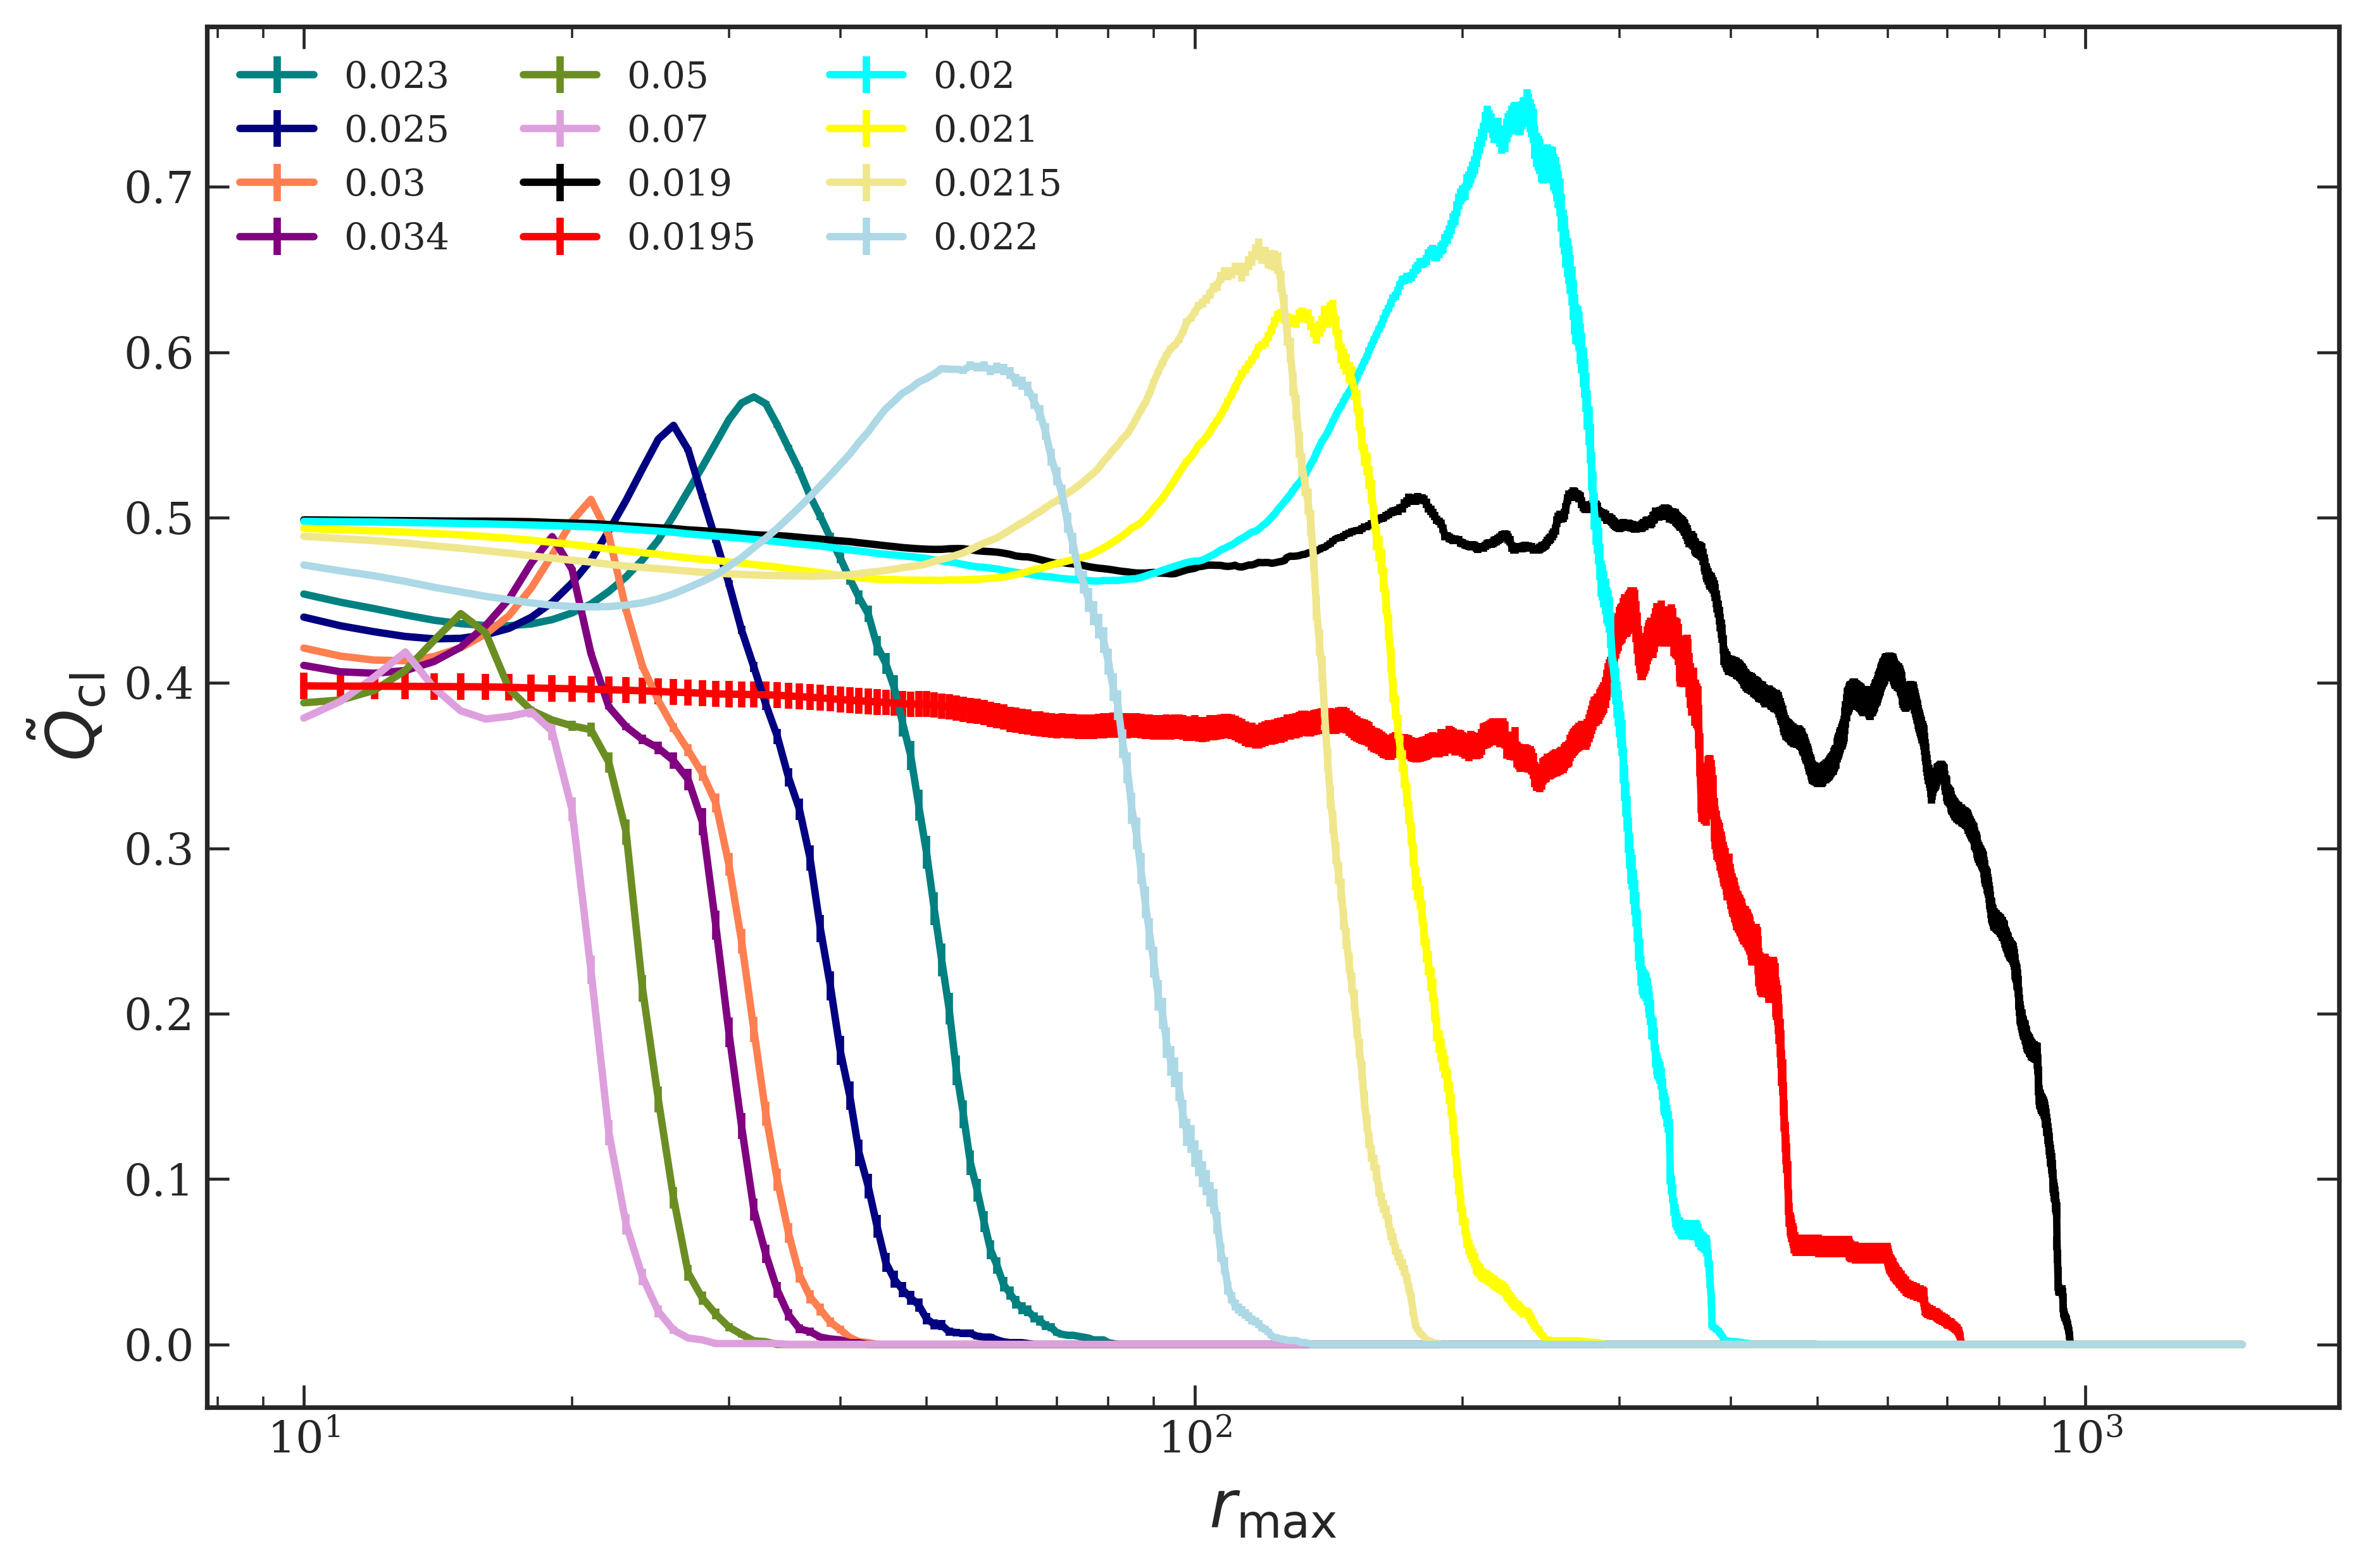

In [86]:
fig, ax = plt.subplots()
for j, act_list in enumerate([act_l[:]]):
    conv_list = ad.conv_list[0]
    for i, act in enumerate(act_list[:-2]):
        if act in [0.024, 0.028, 0.06]:
            continue
        ff_idx = conv_list[i]
        qav = np.nanmean(qarr_shifted[ff_idx:, :, i, :], axis=(0,-1))
        qstd = np.nanstd(qarr_shifted[ff_idx:, :, i, :], axis=(0,-1)) \
        / np.sqrt((Nframes_l - ff_idx) * len(Nexp_l))

        ax.errorbar(rmax_list_l, qav, qstd, label=f'{act}')

for j, act_list in enumerate([act_vl]):
    conv_list = ad.conv_list[-1]
    for i, act in enumerate(act_list):
        ff_idx = conv_list[i]
        qav = np.nanmean(qarr_l_shifted[ff_idx:, :, i, :], axis=(0,-1))
        qstd = np.nanstd(qarr_l_shifted[ff_idx:, :, i, :], axis=(0,-1)) \
        / np.sqrt((Nframes_vl - ff_idx) * len(Nexp_vl))

        ax.errorbar(rmax_list_vl, qav, qstd, label=f'{act}')

ax.legend(ncols=3,fontsize=10)
ax.set_xscale('log')

ax.set_xlabel(r'$r_{\max}$')
ax.set_ylabel(r'$\tilde{Q}_{\mathrm{cl}}$')

fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, 'qcl_shift.png'), bbox_inches = 'tight', dpi = 420)

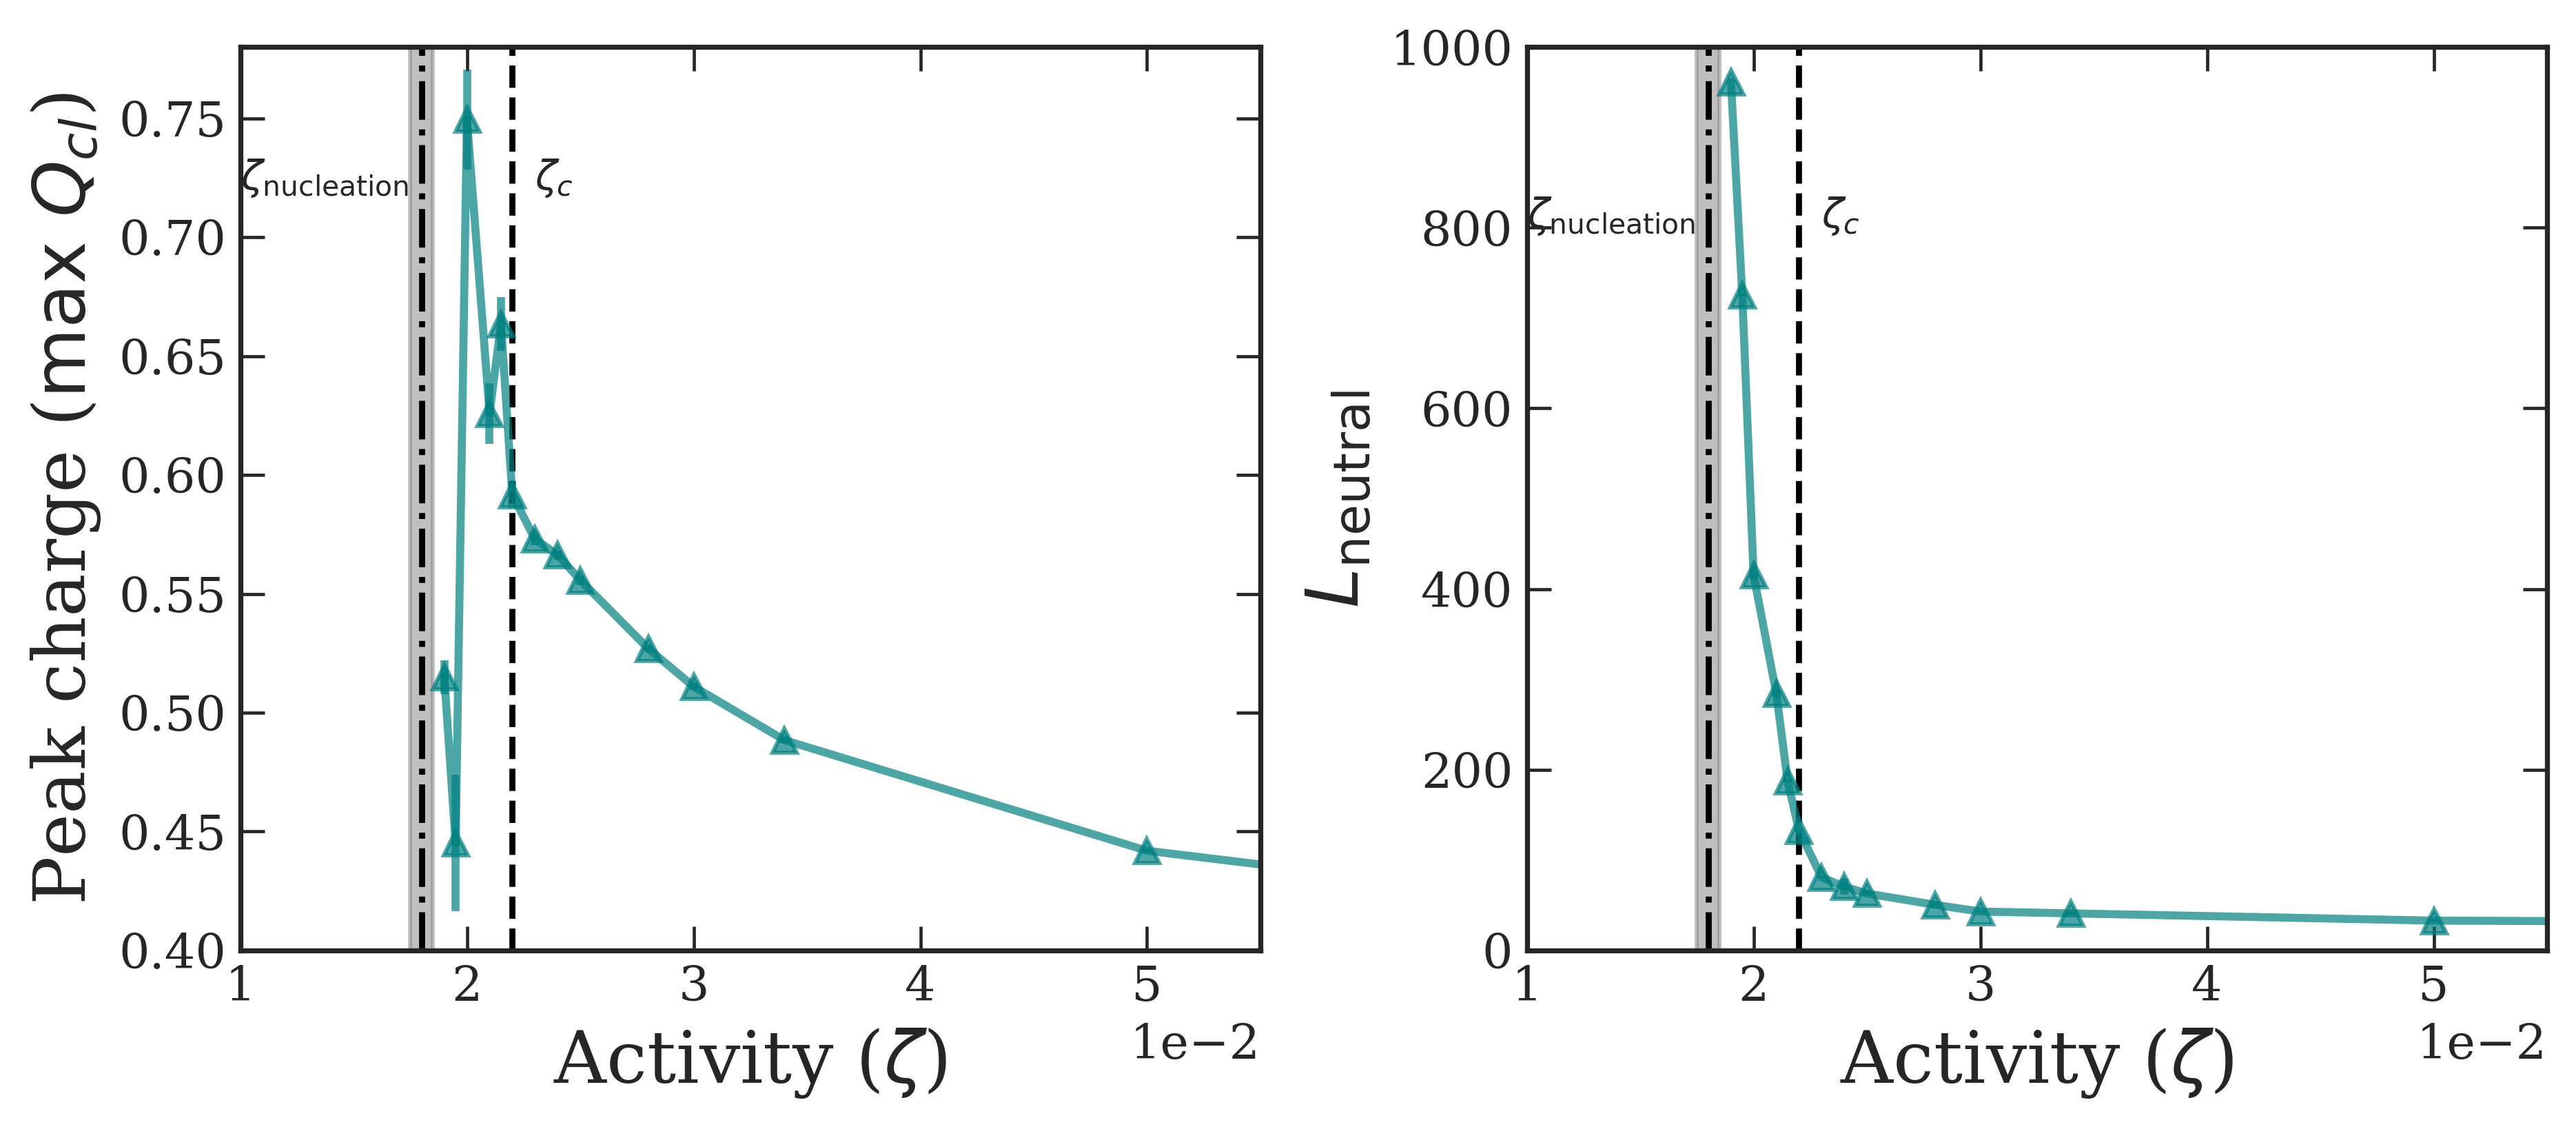

In [68]:
fig, ax = plt.subplots(ncols=2, figsize = (9, 4))

ax[0].errorbar(act_list_full, qpeak_full[:, 0], yerr = qpeak_full[:, 1],  fmt = '^-', alpha=.7)
ax[0].set_xlabel(r'Activity ($\zeta$)')
ax[0].set_ylabel(r'Peak charge ($\mathrm{max} ~Q_{cl}$)')

ax[1].errorbar(act_list_full, lneutral_full[:, 0], yerr = lneutral_full[:, 1], fmt = '^-', alpha=.7)
ax[1].set_xlabel(r'Activity ($\zeta$)')
ax[1].set_ylabel(r'$L_{\mathrm{neutral}}$')

for i, axx in enumerate(ax):

    axx.set_xlabel(r'Activity ($\zeta$)')
    axx.set_xlim(0.01,0.055)
    axx.set_ylim(.4 if i == 0 else 0, 0.78 if i == 0 else 1000)
    axx.vlines(0.018, .4 if i == 0 else 0, 0.78 if i == 0 else 1000, linestyle = '-.', lw=1.5, color = 'k')
    axx.fill_betweenx([.4 if i == 0 else 0, 0.78 if i == 0 else 1000], 0.0175, 0.0185, color = 'gray', alpha = 0.5)
    axx.vlines(0.022, .4 if i == 0 else 0, 0.78 if i == 0 else 1000, linestyle = '--', lw=1.5, color = 'k')
    axx.text(0.023, 0.72 if i == 0 else 800, r'$\zeta_c$', fontsize = 10)
    axx.text(0.01, 0.72 if i == 0 else 800, r'$\zeta_{\mathrm{nucleation}}$', fontsize = 10)

if save_figs:
    fig.savefig(os.path.join(fig_path, 'qpeak_lneutral.png'), bbox_inches = 'tight', dpi = 420)

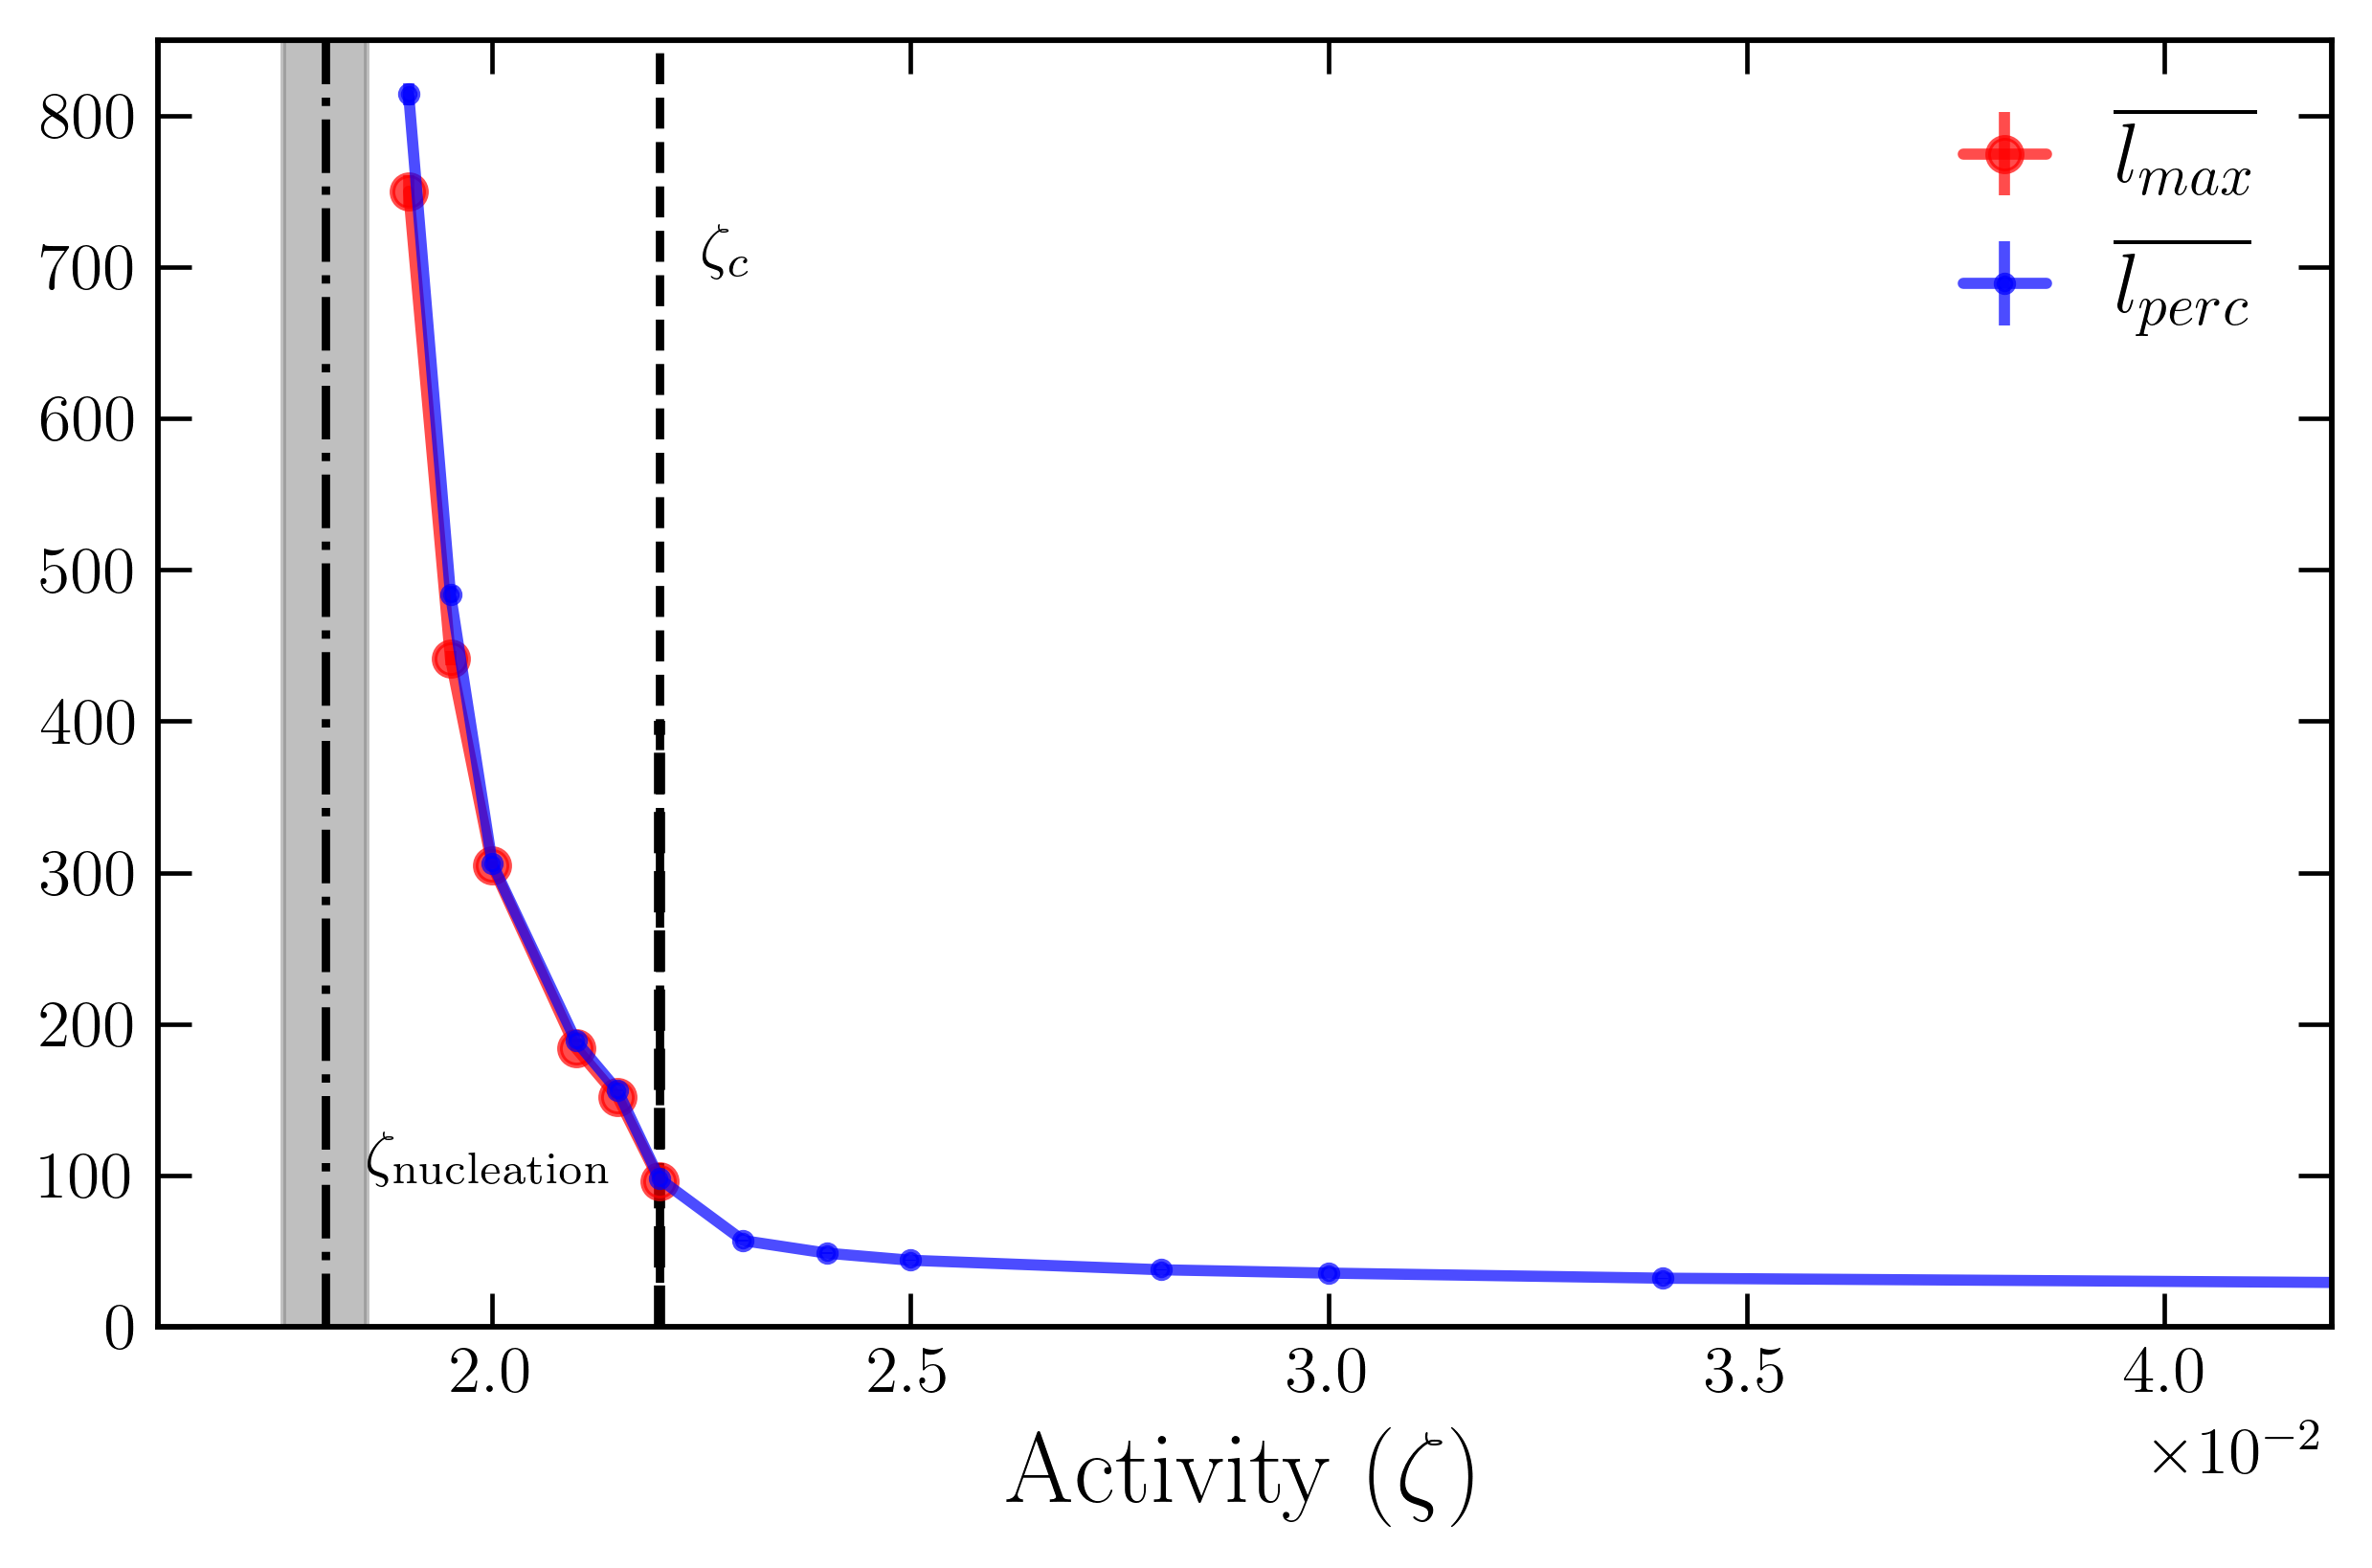

In [6]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
ax.errorbar(act_list_full, lmax_full[:,0], yerr=lmax_full[:,1], alpha=.7,fmt='ro-', label=r'$\overline{l_{max}}$')
ax.errorbar(act_list_full, lperc_full[:,0], yerr=lperc_full[:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')

ax.set_xlabel(r'Activity ($\zeta$)')    
ax.legend()
plt.tight_layout()
ax.vlines(0.022,0,400, color='k', linestyle='--')
#ax.set_xscale('log')
ax.set_xlim(xmin=0.016, xmax=0.042)
ax.set_ylim(0,850)

ax.vlines(0.018, 0, 850, linestyle = '-.', lw=1.5, color = 'k')
ax.fill_betweenx([0,850], 0.0175, 0.0185, color = 'gray', alpha = 0.5)
ax.vlines(0.022, 0, 850, linestyle = '--', lw=1.5, color = 'k')
ax.text(0.0225, 700, r'$\zeta_c$', fontsize = 11)
ax.text(0.0185,  100, r'$\zeta_{\mathrm{nucleation}}$', fontsize = 11)

if save_figs:
    fig.savefig(os.path.join(fig_path, 'lmax_lperc.png'), bbox_inches = 'tight', dpi = 420)